##Primo

In [32]:
%%capture
!pip install SchemDraw

In [33]:
%config InlineBackend.figure_format = 'svg'
import SchemDraw as sd
import SchemDraw.elements as e

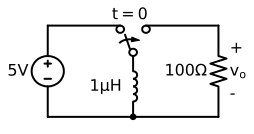

In [35]:
d = sd.Drawing()
V1 = d.add(e.SOURCE_V, label='5V')
d.add(e.LINE, d='right', l=d.unit*.75)
S1 = d.add(e.SWITCH_SPDT2_CLOSE, d='up', anchor='b', rgtlabel='$t=0$')
d.add(e.LINE, d='right', xy=S1.c,  l=d.unit*.75)
d.add(e.RES, d='down', label='$100\Omega$', botlabel=['+','$v_o$','-'])
d.add(e.LINE, to=V1.start)
# d.add(e.CAP, xy=S1.a, d='down', toy=V1.start, label='1$\mu$F')
d.add(e.INDUCTOR, xy=S1.a, d='down', toy=V1.start, label='1$\mu$H')
d.add(e.DOT)
d.draw()

In [8]:
S1.end

array([2.25, 3.  ])

In [9]:
S1.a

array([2.65, 2.  ])

In [10]:
d.here

array([2.65, 0.  ])

In [11]:
e.DOT?


In [15]:
!apt-get install locate

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  locate
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 52.3 kB of archives.
After this operation, 181 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 locate amd64 4.6.0+git+20170828-2 [52.3 kB]
Fetched 52.3 kB in 1s (56.5 kB/s)
Selecting previously unselected package locate.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../locate_4.6.0+git+20170828-2_amd64.deb ...
Unpacking locate (4.6.0+git+20170828-2) ...
Setting up locate (4.6.0+git+20170828-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [16]:
!updatedb

In [17]:
!locate elements.py

/tensorflow-1.15.2/python2.7/tensorflow_core/contrib/copy_graph/python/util/copy_elements.py
/tensorflow-1.15.2/python2.7/tensorflow_core/contrib/copy_graph/python/util/copy_elements.pyc
/tensorflow-1.15.2/python3.6/tensorflow_core/contrib/copy_graph/python/util/copy_elements.py
/usr/local/lib/python2.7/dist-packages/OpenGL/GL/AMD/interleaved_elements.py
/usr/local/lib/python2.7/dist-packages/OpenGL/GL/AMD/interleaved_elements.pyc
/usr/local/lib/python2.7/dist-packages/OpenGL/GL/EXT/draw_range_elements.py
/usr/local/lib/python2.7/dist-packages/OpenGL/GL/EXT/draw_range_elements.pyc
/usr/local/lib/python2.7/dist-packages/OpenGL/raw/GL/AMD/interleaved_elements.py
/usr/local/lib/python2.7/dist-packages/OpenGL/raw/GL/AMD/interleaved_elements.pyc
/usr/local/lib/python2.7/dist-packages/OpenGL/raw/GL/EXT/draw_range_elements.py
/usr/local/lib/python2.7/dist-packages/OpenGL/raw/GL/EXT/draw_range_elements.pyc
/usr/local/lib/python2.7/dist-packages/astropy/coordinates/orbital_elements.py
/usr/loca

In [28]:
!rm /usr/local/lib/python3.6/dist-packages/SchemDraw/elements.py

In [29]:
%%writefile /usr/local/lib/python3.6/dist-packages/SchemDraw/elements.py
'''
Electrical element symbols for schematic drawing.

Each element is defined by a dictionary with key/values defining how it should be drawn.

Coordinates are all defined in element coordinates, where the element begins
at [0,0] and is drawn from left to right. The drawing engine will then rotate
and translate the element to its final position. A standard resistor is
1 drawing unit long, and with default lead extension will become 3 units long.

Possible dictionary keys:
    name:  A name string for the element. Currently only used for testing.
    paths: A list of each path line in the element. For example, a capacitor
           has two paths, one for each capacitor "plate". On 2-terminal
           elements, the leads will be automatically extended away from the
           first and last points of the first path, and don't need to
           be included in the path.
    base:  Dictionary defining a base element. For example, the variable
           resistor has a base of resistor, then adds an additional path.
    shapes: A list of shape dictionaries.
            'shape' key can be ['circle', 'poly', 'arc', 'arrow']
            Other keys depend on the shape as follows.
            circle:
                'center': xy center coordinate
                'radius': radius of circle
                'fill'  : [True, False] fill the circle
                'fillcolor' : color for fill
            poly:
                'xy' : List of xy coordinates defining polygon
                'closed': [True, False] Close the polygon
                'fill'  : [True, False] fill the polygon
                'fillcolor' : color for fill
            arc:
                'center' : Center coordinate of arc
                'width', 'height': width and height of arc
                'theta1' : Starting angle (degrees)
                'theta2' : Ending angle (degrees)
                'angle'  : Rotation angle of entire arc
                'arrow'  : ['cw', 'ccw'] Add an arrowhead, clockwise or counterclockwise
            arrow:
                'start'  : start of arrow
                'end'    : end of arrow
                'headwidth', 'headlength': width and length of arrowhead
    theta: Default angle (in degrees) for the element. Overrides the current
           drawing angle.
    anchors: A dictionary defining named positions within the element. For
             example, the NFET element has a 'source', 'gate', and 'drain'
             anchor. Each anchor will become an attribute of the element class
             which can then be used for connecting other elements.

    extend: [True, False] Extend the leads to fill the full element length.
    move_cur: [True, False] Move the drawing cursor location after drawing.
    color: A matplotlib-compatible color for the element. Examples include
           'red', 'blue', '#34ac92'
    drop: Final location to leave drawing cursor.
    lblloc: ['top', 'bot', 'lft', 'rgt'] default location for text label.
            Defaults to 'top'.
    lblofst: Default distance between element and text label.
    labels: list of label dictionaries. Each label has keys:
            'label' : string label
            'pos'   : xy position
            'align' : (['center', 'left', right'], ['center', 'bottom', 'top']) alignment
            'size'  : font size
'''

import numpy as _np
import re
import warnings

_gap = [_np.nan, _np.nan]   # To leave a break in the plot

# Resistor is defined as 1 matplotlib plot unit long.
# When default leads are added, the total length will be three units.
_rh = 0.25      # Resistor height
_rw = 1.0 / 6   # Full (inner) length of resistor is 1.0 data unit

# Opamp sizes
_oa_back = 2.5
_oa_xlen = _oa_back * _np.sqrt(3)/2
_oa_lblx = _oa_xlen/8


# Drawing Functions
def _cycloid(loops=4, ofst=(0, 0), a=.06, b=.19, norm=True, vertical=False, flip=False):
    ''' Generate a prolate cycloid (inductor spiral) that
        will always start and end at y=0.

        Parameters
        ----------
        loops : int
            Number of loops
        a, b : float
            Parameters. b>a for prolate (loopy) cycloid
        norm : bool
            Normalize the length to 1
        vertical, flip : bool
            Control the orientation of cycloid

        Returns
        -------
        path : array
            List of [x, y] coordinates defining the cycloid
    '''
    yint = _np.arccos(a/b)  # y-intercept
    t = _np.linspace(yint, 2*(loops+1)*_np.pi-yint, num=loops*50)
    x = a*t - b*_np.sin(t)
    y = a - b*_np.cos(t)
    x = x - x[0]  # Shift to start at 0,0

    if norm:
        x = x / (x[-1]-x[0])      # Normalize length to 1

    if flip:
        y = -y

    y = y * (max(y)-min(y))/(_rh)  # Normalize to resistor width

    if vertical:
        x, y = y, x

    x = x + ofst[0]
    y = y + ofst[1]

    path = _np.transpose(_np.vstack((x, y)))
    return path


# Basic elements
RES = {
    'name': 'RES',
    'paths': [[[0, 0], [0.5*_rw, _rh], [1.5*_rw, -_rh], [2.5*_rw, _rh],
               [3.5*_rw, -_rh], [4.5*_rw, _rh], [5.5*_rw, -_rh], [6*_rw, 0]]],
    }

RES_VAR = {
    'name': 'RES_VAR',
    'base': RES,
    'shapes': [{'shape': 'arrow',
                'start': [1.5*_rw, -_rh*2],
                'end': [4.5*_rw, _rw*3.5],
                'headwidth': .12,
                'headlength': .2}],
    'paths': [[[1.5*_rw, -_rh*2], [4.5*_rw, _rw*3.5]]]
     }

RBOX = {
    'name': 'RBOX',
    'paths': [[[0, 0], [0, _rh], [_rw*6, _rh], [_rw*6, -_rh],
               [0, -_rh], [0, 0], _gap, [_rw*6, 0]]]
    }

POT = {
    'name': 'POT',
    'base': RES,
    'shapes': [{'shape': 'arrow',
                'start': [_rw*3, _oa_xlen/3],  # Sized so a pot fits perfectly between opamp offset pins
                'end': [_rw*3, _rw*1.5],
                'headwidth': .15,
                'headlength': .25}],
    'lblloc': 'bot',
    'anchors': {'tap': [_rw*3, _oa_xlen/3]}
     }

_cap_gap = 0.18
CAP = {   # Straight capacitor
    'name': 'CAP',
    'paths': [[[0, 0], _gap, [0, _rh], [0, -_rh], _gap,
               [_cap_gap, _rh], [_cap_gap, -_rh], _gap,
               [_cap_gap, 0]]],
    'anchors': {'center': [_rh, 0]}
    }

CAP_P = {   # Polarized
    'name': 'CAP_P',
    'base': CAP,
    'labels': [{'label': '+',
                'pos': [-_cap_gap*1.2, _cap_gap]}]
    }

CAP2 = {  # Curved capacitor
    'name': 'CAP2',
    'paths': [[[0, 0], _gap, [0, _rh], [0, -_rh], _gap, [_cap_gap, 0]]],
    'shapes': [{'shape': 'arc',
                'center': [(_cap_gap*1.5), 0],
                'theta1': 105,
                'theta2': -105,
                'width': _cap_gap*1.5,
                'height': _rh*2.5}],
    'anchors': {'center': [_rh, 0]}
    }

CAP2_P = {   # Polarized
    'name': 'CAP2_P',
    'base': CAP2,
    'labels': [{'label': '+', 'pos': [-_cap_gap*1.2, _cap_gap]}]
    }

CAP_VAR = {  # Variable cap
    'name': 'CAP_VAR',
    'base': CAP,
    'shapes': [{'shape': 'arrow',
                'start': [-2*_rw, -_rh],
                'end': [3*_rw, _rw*2],
                'headwidth': .12,
                'headlength': .2}],                
    }

_cap_gap = 0.2
XTAL = {   # Crystal
    'name': 'XTAL',
    'paths': [[[0, 0], _gap, [0, _rh], [0, -_rh], _gap,
              [_cap_gap/2, _rh], [_cap_gap/2, -_rh], [_cap_gap*1.5, -_rh],
              [_cap_gap*1.5, _rh], [_cap_gap/2, _rh], _gap,
              [_cap_gap*2, _rh], [_cap_gap*2, -_rh], _gap, [_cap_gap*2, 0]],
             ],
    }

DIODE = {
    'name': 'DIODE',
    'paths': [[[0, 0], _gap, [_rh*1.4, _rh], [_rh*1.4, -_rh], _gap, [_rh*1.4, 0]]],
    'anchors': {'center': [_rh, 0]},
    'shapes': [{'shape': 'poly',
                'xy': _np.array([[0, _rh], [_rh*1.4, 0], [0, -_rh]]),
                'fill': False}]
    }

DIODE_F = {
    'name': 'DIODE_F',
    'paths': [[[0, 0], _gap, [_rh*1.4, _rh], [_rh*1.4, -_rh], _gap, [_rh*1.4, 0]]],
    'anchors': {'center': [_rh, 0]},
    'shapes': [{'shape': 'poly',
                'xy': _np.array([[0, _rh], [_rh*1.4, 0], [0, -_rh]]),
                'fill': True}]
    }

_sd = .1
SCHOTTKY = {  # Schottky diode
    'name': 'SCHOTTKY',
    'base': DIODE,
    'paths': [[[_rh*1.4, _rh], [_rh*1.4-_sd, _rh],  [_rh*1.4-_sd, _rh-_sd]],
              [[_rh*1.4, -_rh], [_rh*1.4+_sd, -_rh], [_rh*1.4+_sd, -_rh+_sd]]]
    }

SCHOTTKY_F = {
    'name': 'SCHOTTKY_F',
    'base': DIODE_F,
    'paths': [[[_rh*1.4, _rh], [_rh*1.4-_sd, _rh],  [_rh*1.4-_sd, _rh-_sd]],
              [[_rh*1.4, -_rh], [_rh*1.4+_sd, -_rh], [_rh*1.4+_sd, -_rh+_sd]]]
    }

DIODE_TUNNEL = {
    'name': 'DIODE_TUNNEL',
    'base': DIODE,
    'paths': [[[_rh*1.4, _rh], [_rh*1.4-_sd, _rh]],
              [[_rh*1.4, -_rh], [_rh*1.4-_sd, -_rh]]]
    }

DIODE_TUNNEL_F = {
    'name': 'DIODE_TUNNEL_F',
    'base': DIODE_F,
    'paths': [[[_rh*1.4, _rh], [_rh*1.4-_sd, _rh]],
              [[_rh*1.4, -_rh], [_rh*1.4-_sd, -_rh]]]
    }

ZENER = {  # Zener diode
    'name': 'ZENER',
    'base': DIODE,
    'paths': [[[_rh*1.4, _rh], [_rh*1.4+_sd, _rh+_sd]],
              [[_rh*1.4, -_rh], [_rh*1.4-_sd, -_rh-_sd]]]
    }

ZENER_F = {
    'name': 'ZENER_F',
    'base': DIODE_F,
    'paths': [[[_rh*1.4, _rh], [_rh*1.4+_sd, _rh+_sd]],
              [[_rh*1.4, -_rh], [_rh*1.4-_sd, -_rh-_sd]]]
    }

LED = {
    'name': 'LED',
    'base': DIODE,
    'paths': [[[_rh, _rh*1.5], [_rh*2, _rh*3.25]]],  # Duplicate arrow with a path to work around matplotlib autoscale bug.
    'shapes': [{'shape': 'arrow',
                'start': [_rh, _rh*1.5],
                'end': [_rh*2, _rh*3.25],
                'headwidth': .12,
                'headlength': .2},
               {'shape': 'arrow',
                'start': [_rh*.1, _rh*1.5],
                'end': [_rh*1.1, _rh*3.25],
                'headwidth': .12,
                'headlength': .2}]
    }

# LED with squiggle light
x = _np.linspace(-1, 1)
y = -x*(x-.7)*(x+.7)/2 + _rh*2.5
x = _np.linspace(_rh*.75, _rh*1.25)
theta = 20
c = _np.cos(_np.radians(theta))
s = _np.sin(_np.radians(theta))
m = _np.array([[c, s], [-s, c]])
p = _np.transpose(_np.vstack((x, y)))
p = _np.dot(p, m)
p2 = _np.transpose(_np.vstack((x-.2, y)))
p2 = _np.dot(p2, m)
LED2 = {
    'name': 'LED2',
    'base': DIODE,
    'paths': [p, p2],
    'shapes': [{'shape': 'arrow',
                'start': p[1],
                'end': p[0],
                'headwidth': .07,
                'headlength': .08
                },
                {'shape': 'arrow',
                 'start': p2[1],
                 'end': p2[0],
                 'headwidth': .07,
                 'headlength': .08
                 }]
    }


# Photodiode with squiggle light
x = _np.linspace(-1, 1)
y = -x*(x-.7)*(x+.7)/2 + _rh*2.5
x = _np.linspace(_rh*.75, _rh*1.25)
theta = 20
c = _np.cos(_np.radians(theta))
s = _np.sin(_np.radians(theta))
m = _np.array([[c, s], [-s, c]])
p = _np.transpose(_np.vstack((x, y)))
p = _np.dot(p, m)
p2 = _np.transpose(_np.vstack((x-.2, y)))
p2 = _np.dot(p2, m)

PHOTODIODE = {
    'name': 'PHOTODIODE',
    'base': DIODE,
    'paths': [p, p2],
    'shapes': [{'shape': 'arrow',
                'start': p[-2],
                'end': p[-1],
                'headwidth': .07,
                'headlength': .08
                },
                {'shape': 'arrow',
                 'start': p2[-2],
                 'end': p2[-1],
                 'headwidth': .07,
                 'headlength': .08
                 }]
    }

DIAC = {
    'name': 'DIAC',
    'paths': [[[0, 0], _gap, [_rh*1.4, _rh*1.8], [_rh*1.4, -_rh*1.8], _gap,
               [0, _rh*1.8], [0, -_rh*1.8], _gap, [_rh*1.4, 0]]],
    'shapes': [{'shape': 'poly',
                'xy': _np.array([[0, -_rh-.25], [_rh*1.4, -.25], [0, -_rh+.25]]),
                'fill': False},
              {'shape': 'poly',
                'xy': _np.array([[_rh*1.4, _rh+.25], [0, .25], [_rh*1.4, _rh-.25]]),
                'fill': False}]
    }

DIAC_F = {
    'name': 'DIAC_F',
    'paths': [[[0, 0], _gap, [_rh*1.4, _rh*1.8], [_rh*1.4, -_rh*1.8], _gap,
               [0, _rh*1.8], [0, -_rh*1.8], _gap, [_rh*1.4, 0]]],
    'shapes': [{'shape': 'poly',
                'xy': _np.array([[0, -_rh-.25], [_rh*1.4, -.25], [0, -_rh+.25]]),
                'fill': True},
              {'shape': 'poly',
                'xy': _np.array([[_rh*1.4, _rh+.25], [0, .25], [_rh*1.4, _rh-.25]]),
                'fill': True}]
    }

TRIAC = {
    'name': 'TRIAC',
    'base': DIAC,
    'paths': [[[_rh*1.4, .25], [_rh*1.4+.5, .5]]],
    'anchors': {'gate': [_rh*1.4+.5, .5]}
    }

TRIAC_F = {
    'name': 'TRIAC_F',
    'base': DIAC_F,
    'paths': [[[_rh*1.4, .25], [_rh*1.4+.5, .5]]],
    'anchors': {'gate': [_rh*1.4+.5, .5]}
    }

SCR = {
    'name': 'SCR',
    'base': DIODE,
    'paths': [[[_rh*1.4, 0], [_rh*1.4+.3, -.3], [_rh*1.4+.3, -.5]]],
    'anchors': {'gate': [_rh*1.4+.3, -.5]}
    }

SCR_F = {
    'name': 'SCR_F',
    'base': DIODE_F,
    'paths': [[[_rh*1.4, 0], [_rh*1.4+.3, -.3], [_rh*1.4+.3, -.5]]],
    'anchors': {'gate': [_rh*1.4+.3, -.5]}
    }

_mr = 0.2
MEMRISTOR = {
    'name': 'MEMRISTOR',
    'paths': [[[0, _mr*1.25], [_mr*5, _mr*1.25], [_mr*5, _mr*-1.25], [0, _mr*-1.25], [0, _mr*1.25]],
              [[0, 0], [_mr, 0], [_mr, -_mr*.75], [_mr*2, -_mr*.75], [_mr*2, _mr*.75], [_mr*3, _mr*.75], [_mr*3, -_mr*.75], [_mr*4, -_mr*.75], [_mr*4, 0], [_mr*5, 0]],
             ],
    'shapes': [{'shape': 'poly',
                  'xy': [[0, _mr*1.25], [0, -_mr*1.25], [_mr/2, -_mr*1.25], [_mr/2, _mr*1.25]],
                  'fill': True
                 }]
    }

_mrv = .25
MEMRISTOR2 = {
    'name': 'MEMRISTOR2',
    'paths': [[[0, 0], [0, _mrv], [_mr, _mrv], [_mr, -_mrv], [_mr*2, -_mrv], [_mr*2, _mrv],
               [_mr*3, _mrv], [_mr*3, -_mrv], [_mr*4, -_mrv], [_mr*4, _mrv],
               [_mr*5, _mrv], [_mr*5, -_mrv], [_mr*6, -_mrv], [_mr*6, 0],
               [_mr*7, 0]],
             ],
    }

JJ = {   # Josphson Junction
    'name': 'JJ',
    'paths': [[[0, 0], _gap, [-_rh, _rh], [_rh, -_rh], _gap, [_rh, _rh], [-_rh, -_rh], _gap, [0, 0]]],
    }

_fuser = .15
_fusex = _np.linspace(_fuser*2, 1+_fuser)
_fusey = _np.sin(_np.linspace(0, 1)*2*_np.pi) * _rh
FUSE = {
    'name': 'FUSE',
    'paths': [_np.transpose(_np.vstack((_fusex, _fusey))),
              [[0, 0], _gap, [1+_fuser*3, 0]]
             ],
    'shapes': [{'shape': 'circle',
                'center': [_fuser, 0],
                'radius': _fuser,
                'fill': True,
                'fillcolor': 'white'},
              {'shape': 'circle',
                'center': [_fuser*2+1, 0],
                'radius': _fuser,
                'fill': True,
                'fillcolor': 'white'}],
    }

# Connection dots, lines
_dotr = .075
DOT_OPEN = {
    'name': 'DOT_OPEN',
    'paths': [[[0, 0]]],
    'shapes': [{'shape': 'circle',
                'center': [0, 0],
                'radius': _dotr,
                'fill': True,
                'fillcolor': 'white',
                'zorder': 4}],
    'theta': 0,
    'extend': False,
    }

DOT = {
    'name': 'DOT',
    'paths': [[[0, 0]]],
    'shapes': [{'shape': 'circle',
                'center': [0, 0],
                'radius':_dotr,
                'fill': True,
                'fillcolor': 'black'}],
    'theta': 0,
    'extend': False,
    }

ARROWHEAD = {
    'name': 'ARROWHEAD',
    'shapes': [{'shape': 'arrow', 'start': [-.3, 0], 'end': [0, 0],
                'headwidth': .3, 'headlength': .3}],
    'lblofst': .25,
    'move_cur': False,
    'extend': False
    }

ELLIPSIS = {
    'name': 'ELLIPSIS',
    'shapes': [{'shape': 'circle',
                'center': [.5, 0],
                'radius': _dotr/2,
                'fill': True,
                'fillcolor': 'black'},
               {'shape': 'circle',
                'center': [1, 0],
                'radius': _dotr/2,
                'fill': True,
                'fillcolor': 'black'},
               {'shape': 'circle',
                'center': [1.5, 0],
                'radius': _dotr/2,
                'fill': True,
                'fillcolor': 'black'}],
    'extend': False,
    'drop': [2, 0]
    }

LINE = {'name': 'LINE', 'paths': [_np.array([[0, 0]])]}

# Label centered over a gap
GAP_LABEL = {
    'name': 'LABEL',
    'paths': [[[0, 0], _gap, [1, 0]]],
    'lblloc': 'center',
    'lblofst': 0,
    'zorder': 0,
    'pathparams': [{'color': 'white'}]
    }

GAP = {
    'base': GAP_LABEL
    }

# Label at the specific location
LABEL = {
    'name': 'LABEL',
    'lblloc': 'center',
    'lblofst': 0,
    'move_cur': False
    }


# Grounds
_gnd_gap = 0.12
_gnd_lead = 0.4
GND = {
    'name': 'GND',
    'paths': [[[0, 0], [0, -_gnd_lead], [-_rh, -_gnd_lead], [_rh, -_gnd_lead],
              _gap, [-_rh*.7, -_gnd_gap-_gnd_lead], [_rh*.7, -_gnd_gap-_gnd_lead],
              _gap, [-_rh*.2, -_gnd_gap*2-_gnd_lead],
              [_rh*.2, -_gnd_gap*2-_gnd_lead]]],
    'move_cur': False,
    'extend': False,
    'theta': 0
    }

GND_SIG = {
    'name': 'GND_SIG',
    'paths': [[[0, 0], [0, -_gnd_lead], [-_rh, -_gnd_lead], [0, -_gnd_lead*2],
              [_rh, -_gnd_lead], [0, -_gnd_lead]]],
    'move_cur': False,
    'extend': False,
    'theta': 0
    }

_chgnd_dx = _rh*.75
_chgnd_dy = _rh
GND_CHASSIS = {
    'name': 'GND_CHASSIS',
    'paths': [[[0, 0], [0, -_gnd_lead], [-_chgnd_dx, -_gnd_lead-_chgnd_dy]],
             [[0, -_gnd_lead], [-_chgnd_dx, -_gnd_lead], [-_chgnd_dx*2, -_gnd_lead-_chgnd_dy]],
             [[0, -_gnd_lead], [_chgnd_dx, -_gnd_lead], [0, -_gnd_lead-_chgnd_dy]]],
    'move_cur': False,
    'extend': False,
    'theta': 0
    }

# antenna
_ant_lead = 0.6
_ant_h = 0.6
_ant_w = 0.38
ANT = {
    'name': 'ANT',
    'paths': [[[0, 0], [0, _ant_lead], [-_ant_w, _ant_lead+_ant_h], [_ant_w, _ant_lead+_ant_h], [0, _ant_lead]]],
    'extend': False,
    'move_cur': False,
    'theta': 0
    }

_chgnd_dx = _rh*.75
_chgnd_dy = _rh
VSS = {
    'name': 'VSS',
    'paths': [[[0, 0], [0, -_gnd_lead]],
              [[0, -_gnd_lead], [-_chgnd_dx, -_gnd_lead]],
              [[0, -_gnd_lead], [_chgnd_dx, -_gnd_lead]]],
    'move_cur': False,
    'extend': False,
    'theta': 0
    }

_chgnd_dx = _rh*.75
_chgnd_dy = _rh
VDD = {
    'name': 'VDD',
    'paths': [[[0, 0], [0, _gnd_lead]],
              [[0, _gnd_lead], [-_chgnd_dx, _gnd_lead]],
              [[0, _gnd_lead], [_chgnd_dx, _gnd_lead]]],
    'move_cur': False,
    'extend': False,
    'theta': 0
    }


# Opamp
_oa_pluslen = .2
OPAMP_NOSIGN = {
    'name': 'OPAMP_NOSIGN',
    'paths': [[[0, 0], [0, _oa_back/2], [_oa_xlen, 0], [0, -_oa_back/2], [0, 0],
              _gap, [_oa_xlen, 0]],  # Triangle
             ],
    'anchors': {'center': [_oa_xlen/2, 0],
                'in1': [0, _oa_back/4],
                'in2': [0, -_oa_back/4],
                'out': [_oa_xlen, 0],
                'vd': [_oa_xlen/3, .84],
                'vs': [_oa_xlen/3, -.84],
                'n1': [_oa_xlen*2/3, -.42],
                'n2': [_oa_xlen*2/3, .42],
                'n1a': [_oa_xlen*.9, -.13],
                'n2a': [_oa_xlen*.9, .13]                
               },
    'extend': False,
    }

OPAMP = {
    'name': 'OPAMP',
    'paths': [[[0, 0], [0, _oa_back/2], [_oa_xlen, 0], [0, -_oa_back/2], [0, 0],  _gap,  [_oa_xlen, 0]], # Triangle
              [[_oa_lblx-_oa_pluslen/2, _oa_back/4], [_oa_lblx+_oa_pluslen/2, _oa_back/4]],    # '-' sign
              [[_oa_lblx-_oa_pluslen/2, -_oa_back/4], [_oa_lblx+_oa_pluslen/2, -_oa_back/4]],  # '+' sign
              [[_oa_lblx, -_oa_back/4-_oa_pluslen/2], [_oa_lblx, -_oa_back/4+_oa_pluslen/2]]   # '' sign
             ],
    'anchors': {'center': [_oa_xlen/2, 0],
                'in1': [0, _oa_back/4],
                'in2': [0, -_oa_back/4],
                'out': [_oa_xlen, 0],
                'vd': [_oa_xlen/3, .84],
                'vs': [_oa_xlen/3, -.84],
                'n1': [_oa_xlen*2/3, -.42],
                'n2': [_oa_xlen*2/3, .42],
                'n1a': [_oa_xlen*.9, -.13],
                'n2a': [_oa_xlen*.9, .13]                
               },
    'extend': False,
    }


# FETs
_fetw = _rw*4
_feth = _rw*5
_fetl = _feth/2
_fet_gap = _rw*1.5
_fetr = _rw*.7  # Radius of "not" bubble
NFET = {
    'name': 'NFET',
    'paths': [[[0, 0], [0, -_fetl], [_fetw, -_fetl], [_fetw, -_fetl-_fetw], [0, -_fetl-_fetw], [0, -2*_fetl-_fetw]],
              [[_fetw+_fet_gap, -_fetl], [_fetw+_fet_gap, -_fetl-_fetw]],
              [[_fetw+_fet_gap, -_fetl-_fetw/2], [_fetw+_fet_gap+_fetl+_fetr, -_fetl-_fetw/2]]],
    'extend': False,
    'drop': _np.array([0, -2*_fetl-_fetw]),
    'lblloc': 'lft',
    'anchors': {'source': [0, -2*_fetl-_fetw],
                'drain': [0, 0],
                'gate': [_fetw+_fet_gap+_fetl+_fetr, -_fetl-_fetw/2]}
     }

NFET4 = {
    'name': 'NFET4',
    'paths': [[[0, 0], [0, -_fetl], [_fetw, -_fetl], [_fetw, -_fetl-_fetw], [0, -_fetl-_fetw], [0, -2*_fetl-_fetw]],
              [[_fetw+_fet_gap, -_fetl], [_fetw+_fet_gap, -_fetl-_fetw]],
              [[_fetw+_fet_gap, -_fetl-_fetw/2], [_fetw+_fet_gap+_fetl+_fetr, -_fetl-_fetw/2]]],
    'shapes': [{'shape': 'arrow',
                'start': [0, -_fetl-_fetw/2],
                'end': [_fetw, -_fetl-_fetw/2],
                'headwidth': 0.2
                }],
    'extend': False,
    'drop': _np.array([0, -2*_fetl-_fetw]),
    'lblloc': 'lft',
    'anchors': {'source': [0, -2*_fetl-_fetw],
                'drain': [0, 0],
                'gate': [_fetw+_fet_gap+_fetl+_fetr, -_fetl-_fetw/2],
                'bulk': [0, -_fetl-_fetw/2]}
     }

PFET = {
    'name': 'PFET',
    'paths': [[[0, 0], [0, -_fetl], [_fetw, -_fetl], [_fetw, -_fetl-_fetw], [0, -_fetl-_fetw], [0, -2*_fetl-_fetw]],
              [[_fetw+_fet_gap, -_fetl], [_fetw+_fet_gap, -_fetl-_fetw]],
              [[_fetw+_fet_gap+_fetr*2, -_fetl-_fetw/2], [_fetw+_fet_gap+_fetl+_fetr, -_fetl-_fetw/2]]],
    'shapes': [{'shape': 'circle',
                'center': [_fetw+_fet_gap+_fetr, -_fetl-_fetw/2],
                'radius': _fetr}],
    'extend': False,
    'drop': _np.array([0, -2*_fetl-_fetw]),
    'lblloc': 'lft',
    'anchors': {'source': [0, 0],
                'drain': [0, -2*_fetl-_fetw],
                'gate': [_fetw+_fet_gap+_fetl+_fetr, -_fetl-_fetw/2]}
     }

PFET4 = {
    'name': 'PFET4',
    'paths': [[[0, 0], [0, -_fetl], [_fetw, -_fetl], [_fetw, -_fetl-_fetw], [0, -_fetl-_fetw], [0, -2*_fetl-_fetw]],
              [[_fetw+_fet_gap, -_fetl], [_fetw+_fet_gap, -_fetl-_fetw]],
              [[_fetw+_fet_gap, -_fetl-_fetw/2], [_fetw+_fet_gap+_fetl+_fetr, -_fetl-_fetw/2]]],
    'shapes': [{'shape': 'arrow',
                'start': [_fetw, -_fetl-_fetw/2],
                'end': [0, -_fetl-_fetw/2],
                'headwidth': 0.2
                }],
    'extend': False,
    'drop': _np.array([0, -2*_fetl-_fetw]),
    'lblloc': 'lft',
    'anchors': {'source': [0, 0],
                'drain': [0, -2*_fetl-_fetw],
                'gate': [_fetw+_fet_gap+_fetl+_fetr, -_fetl-_fetw/2],
                'bulk': [0, -_fetl-_fetw/2]}
     }

# Junction FETs
_fete = _fetw*.2  # JFET extension
_jfetw = _rw*3

_JFET_BASE = {
    'paths': [[[0, 0], [0, -_fetl], [_jfetw, -_fetl], [_jfetw, -_fetl+_fete], [_jfetw, -_fetl-_jfetw-_fete],
               [_jfetw, -_fetl-_jfetw], [0, -_fetl-_jfetw], [0, -2*_fetl-_jfetw]],
              [[_jfetw, -_fetl-_jfetw], [_jfetw+_fetl, -_fetl-_jfetw]]
             ],
    'extend': False,
    'drop': _np.array([_jfetw+_fetl, -_fetl-_jfetw]),
    'lblloc': 'lft',
    'anchors': {'source': [0, -2*_fetl-_jfetw],
                'drain': [0, 0],
                'gate': [_jfetw+_fetl, -_fetl-_jfetw]}
    }

JFET_N = {
    'name': 'JFET_N',
    'base': _JFET_BASE,
    'shapes': [{'shape': 'arrow',
                'start': [_jfetw+.1, -_fetl-_jfetw],
                'end': [_jfetw+.3, -_fetl-_jfetw],
                'headwidth': .3,
                'headlength': .2}],
    }

JFET_N_C = {
    'name': 'JFET_N_C',
    'base': JFET_N,
    'shapes': [{'shape': 'circle',
                'center': [_jfetw/2, -_fetw],
                'radius': _fetw*1.1}]
    }

JFET_P = {
    'name': 'JFET_P',
    'base': _JFET_BASE,
    'shapes': [{'shape': 'arrow',
                'start': [_jfetw+.25, -_fetl-_jfetw],
                'end': [_jfetw, -_fetl-_jfetw],
                'headwidth': .3,
                'headlength': .25}]
    }

JFET_P_C = {
    'name': 'JFET_P_C',
    'base': JFET_P,
    'shapes': [{'shape': 'circle',
                'center': [_jfetw/2, -_fetw],
                'radius': _fetw*1.1}]
    }


# BJT transistors
_bjt_r = _rw*3.3   # Radius of BJT circle
_bjt_v = _bjt_r*2/3  # x coord of vertical line
_bjt_v_len = _bjt_r*4/3  # height of vertical line
_bjt_a = _bjt_v_len/4    # Intercept of emitter/collector lines
_bjt_emx = _bjt_v + _bjt_r*.7  # x-coord of emitter exiting circle
_bjt_emy = _bjt_v_len*.7    # y-coord of emitter exiting circle

BJT = {
    'name': 'BJT',
    'paths': [[[0, 0], [_bjt_v, 0]],
              [[_bjt_v, _bjt_v_len/2], [_bjt_v, -_bjt_v_len/2]],
              [[_bjt_v, _bjt_a], [_bjt_emx, _bjt_emy], [_bjt_emx, _bjt_emy+_bjt_a]],
              [[_bjt_v, -_bjt_a], [_bjt_emx, -_bjt_emy], [_bjt_emx, -_bjt_emy-_bjt_a]]],
    'extend': False,
    'drop': _np.array([_bjt_emx, _bjt_emy+_bjt_a]),
    'lblloc': 'rgt',
    'anchors': {'base': [0, 0],
                'collector': [_bjt_emx, _bjt_emy+_bjt_a],
                'emitter': [_bjt_emx, -_bjt_emy-_bjt_a]}
    }

BJT_NPN = {
    'name': 'BJT_NPN',
    'base': BJT,
    'shapes': [{'shape': 'arrow',
                'start': [_bjt_v, -_bjt_a],
                'end': [_bjt_emx, -_bjt_emy],
                'headwidth': 0.2
                }]
    }

BJT_PNP = {
    'name': 'BJT_PNP',
    'base': BJT,
    'shapes': [{'shape': 'arrow',
                'end': [_bjt_v, _bjt_a],
                'start': [_bjt_emx, _bjt_emy],
                'headwidth': 0.2
                }],
    'anchors': {'base': [0, 0],
                'emitter': [_bjt_emx, _bjt_emy+_bjt_a],
                'collector': [_bjt_emx, -_bjt_emy-_bjt_a]}
     }

BJT_NPN_C = {
    'name': 'BJT_NPN_C',
    'base': BJT_NPN,
    'shapes': [{'shape': 'circle',
                'center': [_bjt_r, 0],
                'radius': _bjt_r}]
    }

BJT_PNP_C = {
    'name': 'BJT_PNP_C',
    'base': BJT_PNP,
    'shapes': [{'shape': 'circle',
                'center': [_bjt_r, 0],
                'radius': _bjt_r}]
    }

# BJT's with two collectors
_bjt_2c_dy = -.25
BJT_PNP_2C = {
    'name': 'BJT_PNP_2C',
    'base': BJT_PNP,
    'paths': [[[_bjt_v, -_bjt_a-_bjt_2c_dy], [_bjt_emx, -_bjt_emy-_bjt_2c_dy]]],
    'anchors': {'C2': [_bjt_emx, -_bjt_emy-_bjt_2c_dy]}
}

# Inductor without spiraling
_ind_w = .25
_ind_shape_list = []
for _i in range(4):
    _ind_shape_list.append({'shape': 'arc',
                            'center': [(_i*2+1)*_ind_w/2, 0],
                            'theta1': 0,
                            'theta2': 180,
                            'width': _ind_w,
                            'height': _ind_w})
INDUCTOR = {
    'name': 'INDUCTOR',
    'paths': [[[0, 0], _gap, [1, 0]]],
    'shapes': _ind_shape_list}

INDUCTOR2 = {
    'name': 'INDUCTOR2',
    'paths': [_cycloid(loops=3)]
    }

# Independent sources
SOURCE = {
    'name': 'SOURCE',
    'paths': [[[0, 0], [0, 0], _gap, [1, 0], [1, 0]]],
    'theta': 90.,
    'shapes': [{'shape': 'circle',
                'center': [0.5, 0],
                'radius': 0.5}],
     }

_plus_len = .2
SOURCE_V = {
    'name': 'SOURCE_V',
    'base': SOURCE,
    'paths': [[[.25, -_plus_len/2], [.25, _plus_len/2]],     # '-' sign
              [[.75-_plus_len/2, 0], [.75+_plus_len/2, 0]],  # '+' sign
              [[.75, -_plus_len/2], [.75, _plus_len/2]],    # '+' sign
              ]
    }

SOURCE_I = {
    'name': 'SOURCE_I',
    'base': SOURCE,
    'shapes': [{'shape': 'arrow',
                'end': [.75, 0],
                'start': [.25, 0]}]
    }


_sin_y = _np.linspace(.25, .75, num=25) - 0.5
_sin_x = .2 * _np.sin((_sin_y-.25)*_np.pi*2/.5) + 0.5
_sin_path = _np.transpose(_np.vstack((_sin_x, _sin_y)))
SOURCE_SIN = {
    'name': 'SOURCE_SIN',
    'base': SOURCE,
    'paths': [_sin_path]
    }


#Controlled sources
SOURCE_CONT = {
    'name': 'SOURCE_CONT',
    'paths': [[[0, 0], [.5, .5], [1, 0], [.5, -.5], [0, 0], _gap, [1, 0]]],
    'theta': 90.,
     }

SOURCE_CONT_V = {
    'name': 'SOURCE_CONT_V',
    'base': SOURCE_CONT,
    'paths': [[[.25, -_plus_len/2], [.25, _plus_len/2]],     # '-' sign
              [[.75-_plus_len/2, 0], [.75+_plus_len/2, 0]],  # '+' sign
              [[.75, -_plus_len/2], [.75, _plus_len/2]],    # '+' sign
             ]
    }

SOURCE_CONT_I = {
    'name': 'SOURCE_CONT_I',
    'base': SOURCE_CONT,
    'shapes': [{'shape': 'arrow',
                'end': [.75, 0],
                'start': [.25, 0]}]
    }

# Batteries
_batw = _rh*.75
_bat1 = _rh*1.5
_bat2 = _rh*.75
BAT_CELL = {
    'name': 'BAT_CELL',
    'paths': [[[0, _bat1], [0, -_bat1]],
              [[_batw, _bat2], [_batw, -_bat2]],
              [[0, 0], _gap, [_batw, 0]]
             ]
    }

BATTERY = {
    'name': 'BATTERY',
    'paths': [[[0, _bat1], [0, -_bat1]],
              [[_batw, _bat2], [_batw, -_bat2]],
              [[_batw*2, _bat1], [_batw*2, -_bat1]],
              [[_batw*3, _bat2], [_batw*3, -_bat2]],
              [[0, 0], _gap, [_batw*3, 0]]
             ]
    }


# Meters
METER_V = {
    'name': 'METER_V',
    'base': SOURCE,
    'labels': [{'label': 'V', 'pos': [.5, 0]}]
    }

METER_I = {
    'name': 'METER_I',
    'base': SOURCE,
    'labels': [{'label': 'I', 'pos': [.5, 0]}]
    }

METER_OHM = {
    'name': 'METER_OHM',
    'base': SOURCE,
    'labels': [{'label': '$\Omega$', 'pos': [.5, 0]}]
    }


# Arrows for labeling current
ARROWLINE = {
    'name': 'ARROWLINE',
    'paths': [[[0, 0], [1, 0]]],
    'shapes': [{'shape': 'arrow',
                'start': [0, 0],
                'end': [0.55, 0],
                'headwidth': .2,
                'headlength': .3}],
    'lblofst': .2,
    }

ARROW_I = {
    'name': 'ARROW_I',
    'shapes': [{'shape': 'arrow',
                'start': [0, 0],
                'end': [2, 0],
                'headwidth': .2,
                'headlength': .3}],
    'anchors': {'center': [1, 0]},
    'lblofst': .2,
    'move_cur': False
    }

# Switches
_sw_dot_r = .12
SWITCH_SPST = {
    'name': 'SWITCH_SPST',
    'paths': [[[0, 0], _gap, [_sw_dot_r*2, .1], [.8, .45], _gap, [1, 0]]],
    'shapes': [{'shape': 'circle',
                'center': [_sw_dot_r, 0],
                'radius': _sw_dot_r},
               {'shape': 'circle',
                'center': [1-_sw_dot_r, 0],
                'radius': _sw_dot_r}]
    }

SWITCH_SPST_OPEN = {
    'name': 'SWITCH_SPST_OPEN',
    'base': SWITCH_SPST,
    'shapes': [{'shape': 'arc',
                'center': [.4, .1],
                'width': .5,
                'height': .75,
                'theta1': -10,
                'theta2': 70,
                'arrow': 'ccw'}]
    }

SWITCH_SPST_CLOSE = {
    'name': 'SWITCH_SPST_CLOSE',
    'base': SWITCH_SPST,
    'shapes': [{'shape': 'arc',
                'center': [.4, .25],
                'width': .5,
                'height': .75,
                'theta1': -10,
                'theta2': 70,
                'arrow': 'cw'}]
    }

SWITCH_SPDT = {
    'name': 'SWITCH_SPDT',
    'base': SWITCH_SPST,
    'shapes': [{'shape': 'circle',
                'center': [1-_sw_dot_r, .7],
                'radius': _sw_dot_r}],
    'anchors': {'a': [0, 0],
                'b': [1, 0],
                'c': [1, .7]},
    'extend': False
    }

SWITCH_SPDT_OPEN = {
    'name': 'SWITCH_SPDT_OPEN',
    'base': SWITCH_SPST_OPEN,
    'shapes': [{'shape': 'circle',
                'center': [1-_sw_dot_r, .7],
                'radius': _sw_dot_r}],
    'extend': False
    }

SWITCH_SPDT_CLOSE = {
    'name': 'SWITCH_SPDT_CLOSE',
    'base': SWITCH_SPST_CLOSE,
    'shapes': [{'shape': 'circle',
                'center': [1-_sw_dot_r, .7],
                'radius': _sw_dot_r}],
    'extend': False
    }

SWITCH_SPDT2 = {
    'name': 'SWITCH_SPDT2',
    'paths': [[[0, 0], _gap, [_sw_dot_r*2, .1], [.7, .25], _gap, [1, .4]]],
    'shapes': [{'shape': 'circle',
                'center': [_sw_dot_r, 0],
                'radius': _sw_dot_r},
               {'shape': 'circle',
                'center': [1-_sw_dot_r, -.4],
                'radius': _sw_dot_r},
               {'shape': 'circle',
                'center': [1-_sw_dot_r, .4],
                'radius': _sw_dot_r}],
    'anchors': {'a': [0, 0],
                'b': [1, .4],
                'c': [1, -.4]},
    'extend': False
    }

SWITCH_SPDT2_OPEN = {
    'name': 'SWITCH_SPDT2_OPEN',
    'base': SWITCH_SPDT2,
    'shapes': [{'shape': 'arc',
                'center': [.35, 0],
                'width': .5,
                'height': .75,
                'theta1': -10,
                'theta2': 70,
                'arrow': 'ccw'}]
    }

SWITCH_SPDT2_CLOSE = {
    'name': 'SWITCH_SPDT2_CLOSE',
    'base': SWITCH_SPDT2,
    'shapes': [{'shape': 'arc',
                'center': [.3, .1],
                'width': .5,
                'height': .75,
                'theta1': -10,
                'theta2': 70,
                'arrow': 'cw'}]
    }

# Pushbuttons
BUTTON = {
    'name': 'BUTTON',
    'paths': [[[0, 0], _gap, [_sw_dot_r, .3], [1-_sw_dot_r, .3],
               _gap, [.5, .3], [.5, .5], _gap, [1, 0]]],
    'shapes': [{'shape': 'circle',
                'center': [_sw_dot_r, 0],
                'radius': _sw_dot_r},
               {'shape': 'circle',
                'center': [1-_sw_dot_r, 0],
                'radius': _sw_dot_r}]
    }

BUTTON_NC = {
    'name': 'BUTTON_NC',
    'paths': [[[0, 0], _gap, [_sw_dot_r, -_sw_dot_r-.05],
               [1-_sw_dot_r, -_sw_dot_r-.05], _gap, [.5, -_sw_dot_r-.05],
               [.5, _sw_dot_r+.15], _gap, [1, 0]]],
    'shapes': [{'shape': 'circle',
                'center': [_sw_dot_r, 0],
                'radius': _sw_dot_r},
               {'shape': 'circle',
                'center': [1-_sw_dot_r, 0],
                'radius': _sw_dot_r}]
    }


# Speakers, bulbs, etc.
_sph = .5
SPEAKER = {
    'name': 'SPEAKER',
    'paths': [[[0, 0], [_rh, 0]],
              [[0, -_sph], [_rh, -_sph]]],
    'drop': [0, -_sph],
    'extend': False,
    'shapes': [{'shape': 'poly',
                'xy': [[_rh, _sph/2], [_rh, -_sph*1.5], [_rh*2, -_sph*1.5], [_rh*2, _sph/2]]},
               {'shape': 'poly',
                'xy': [[_rh*2, _sph/2], [_rh*3.5, _sph*1.25], [_rh*3.5, -_sph*2.25], [_rh*2, -_sph*1.5]],
                'closed': False}],
    'anchors': {'in1': [0, 0], 'in2': [0, -_sph]}
    }

MIC = {'name': 'MIC',
       'paths': [[[0, 0], [_rh, 0]],                 # Upper lead
                 [[0, -_sph], [_rh, -_sph]],         # Lower lead
                 [[-_rh*2, _rh], [-_rh*2, -_rh*3]]], # Vertical flat
       'shapes': [{'shape': 'arc',
                   'center': [-_rh*2, -_rh],
                   'theta1': 270,
                   'theta2': 90,
                   'width': _rh*4,
                   'height': 4*_rh}],
       'drop': [0, -_sph],
       'extend': False,
       'anchors': {'in1': [0, 0], 'in2': [0, -_sph]}
      }

_a = .25
_b = .7
_t = _np.linspace(1.4, 3.6*_np.pi, 100)
_x = _a*_t - _b*_np.sin(_t)
_y = _a - _b * _np.cos(_t)
_x = (_x - _x[0])  # Scale to about the right size
_x = _x / _x[-1]
_y = (_y - _y[0]) * .25
_lamp_path = _np.transpose(_np.vstack((_x, _y)))
LAMP = {
    'name': 'LAMP',
    'base': SOURCE,
    'paths': [_lamp_path]
    }

_mw = .22
MOTOR = {'name': 'MOTOR',
         'paths': [[[0, -_mw], [0-_mw, -_mw], [0-_mw, _mw], [0, _mw]],
                   [[1, -_mw], [1+_mw, -_mw], [1+_mw, _mw], [1, _mw]],             
                   [[-_mw, 0], [-_mw, 0], _gap, [1+_mw, 0], [1+_mw, 0]]],
         'shapes': [{'shape': 'circle',
                     'center': [0.5, 0],
                     'radius': 0.5}],
         }


def transformer(t1=4, t2=4, core=True, ltaps=None, rtaps=None, loop=False):
    ''' Generate a transformer element

        Parameters
        ----------
        t1, t2 : int
            Turns on primary (left) and scondary (right) sides
        core : bool
            Draw the core (parallel lines)
        ltaps : dict
            Dictionary of name:position pairs, position is the turn number
            from the top to tap. Each tap defines an anchor point but does
            not draw anything.
        rtaps : dict
            Same as ltaps, on right side
        loop : bool
            Use spiral/cycloid (loopy) style

        Returns
        -------
        elm : dict
            The transformer element definition dictionary
    '''
    # Set initial parameters
    ind_w = .4
    lbot = 0
    ltop = t1*ind_w
    rtop = (ltop+lbot)/2 + t2*ind_w/2
    rbot = (ltop+lbot)/2 - t2*ind_w/2

    element = {'name': 'TRANSFORMER',
               'extend': False,
               'paths': []}

    # Adjust for loops or core
    ind_gap = .75
    if loop:
        ind_gap = ind_gap + .4
    if core:
        ind_gap = ind_gap + .25

    ltapx = 0
    rtapx = ind_gap

    # Draw coils
    if loop:
        c1 = _cycloid(loops=t1, ofst=(0, 0), norm=False, vertical=True)
        c2 = _cycloid(loops=t2, ofst=(ind_gap, -rtop+ltop), norm=False, flip=True, vertical=True)
        ltapx = min([i[0] for i in c1])
        rtapx = max([i[0] for i in c2])
        ltop = c1[-1][1]
        rtop = c2[-1][1]
        element['paths'].extend([c1, c2])
    else:
        shapes = []
        for i in range(t1):
            shapes.append({'shape': 'arc',
                           'center': [0, ltop-(i*ind_w+ind_w/2)],
                           'theta1': 270,
                           'theta2': 90,
                           'width': ind_w,
                           'height': ind_w})
        for i in range(t2):
            shapes.append({'shape': 'arc',
                           'center': [ind_gap, rtop-(i*ind_w+ind_w/2)],
                           'theta1': 90,
                           'theta2': 270,
                           'width': ind_w,
                           'height': ind_w})
        element['shapes'] = shapes

    # Add the core
    if core:
        top = max(ltop, rtop)
        bot = min(lbot, rbot)
        center = ind_gap/2
        core_w = ind_gap/10
        element['paths'].extend([[[center-core_w, top], [center-core_w, bot]],
                                 [[center+core_w, top], [center+core_w, bot]]])

    anchors = {'p1': [0, ltop],
               'p2': [0, lbot],
               's1': [ind_gap, rtop],
               's2': [ind_gap, rbot]}

    if ltaps:
        for name, pos in ltaps.items():
            anchors[name] = [ltapx, ltop - pos * ind_w]
    if rtaps:
        for name, pos in rtaps.items():
            anchors[name] = [rtapx, rtop - pos * ind_w]

    element['anchors'] = anchors
    return element


def ic(*pins, **kwargs):
    ''' Define an integrated circuit element
    
        Parameters
        ----------
        *pins: dict
            A dictionary defining each input/output pin.
            Each dictionary may contain the following 
            optional keys:

            name: string
                Signal name, labeled inside the IC box.
                If name is '>', a proper clock input triangle
                will be drawn instead of a text label.
            pin: string
                Pin name, labeled outside the IC box
            side: string ['left', 'right', 'top', 'bottom']
                Which side the pin belongs on
            pos: float
                Absolute position as fraction from 0-1 along the
                side. If not provided, pins are evenly spaced along 
                the side.
            slot: string
                Position designation for the pin in "X/Y" format
                where X is the pin number and Y the total number
                of pins along the side. Use when missing pins
                are desired with even spacing.
            invert: bool
                Draw an invert bubble outside the pin
            invertradius: float
                Radius of invert bubble
            color: string
                Matplotlib color for label
            rotation: float
                Rotation angle for label (degrees)
            anchorname: string
                Name of anchor at end of pin lead. By default pins
                will have anchors of both the `name` parameter 
                and `inXY` where X the side designation
                ['L', 'R', 'T', 'B'] and Y the pin number along 
                that side.
            
        Keyword Arguments
        -----------------
        size: (w, h) tuple
            Size of the IC. If not provided, size is
            automatically determined based on number of
            pins and the pinspacing parameter.
        pinspacing: float
            Smallest distance between pins [1.25]
        edgepadH: float
            Additional distance from edge to first pin on
            vertical sides [.25]
        edgepadW: float
            Additional distance from edge to first pin on
            horizontal sides [.25]
        lblofst: float
            Default offset for (internal) labels [.15]
        plblofst: float
            Default offset for external pin labels [.1]
        leadlen: float
            Length of leads extending from box [.5]
        lblsize: int
            Font size for (internal) labels [14]
        plblsize: int
            Font size for external pin labels [11]
        slant: float
            Degrees to slant top and bottom sides,
            (e.g. for multiplexers) [0]
    '''
    pinspacing = kwargs.get('pinspacing', 1.25)
    edgepadH = kwargs.get('edgepadH', .25)
    edgepadW = kwargs.get('edgepadW', .25)
    lblofst = kwargs.get('lblofst', .15)
    lblsize = kwargs.get('lblsize', 14)
    leadlen = kwargs.get('leadlen', 0.5)
    plblofst = kwargs.get('plblofst', .1)
    plblsize = kwargs.get('plblsize', 11)
    slant = kwargs.get('slant', 0)

    # Sort pins by side
    pins = [p.copy() for p in pins]  # Make copy so user's dicts don't change
    for pin in pins:
        pin['side'] = pin.get('side', 'L')[:1].upper()  # Convert pin designations to uppercase, single letter
    sidepins = {}
    pincount = {}

    for side in ['L', 'R', 'T', 'B']:
        sidepins[side] = [p for p in pins if p['side'] == side]
        slots = [p.get('slot', None) for p in sidepins[side]]
        slots = [int(p.split('/')[1]) for p in slots if p is not None] + [0]  # Add a 0 - can't max an empty list
        pincount[side] = max(len(sidepins[side]), max(slots))        

    if 'size' not in kwargs:
        hcnt = max(pincount.get('L', 1), pincount.get('R', 1))
        wcnt = max(pincount.get('T', 1), pincount.get('B', 1)) 
        try:
            h = (hcnt-1)*pinspacing/(1-2/(hcnt+2)) + edgepadH*2
        except ZeroDivisionError:
            h = 2 + edgepadH
        try:
            w = (wcnt-1)*pinspacing/(1-2/(wcnt+2)) + edgepadW*2
        except ZeroDivisionError:
            w = 2 + edgepadW

        w = max(w, 2)  # Keep a minimum width for cases with 0-1 pins
        h = max(h, 2)
    else:
        w, h = kwargs.get('size')

    # Main box, adjusted for slant
    shapes = []
    labels = []
    anchors = {}
    if slant > 0:
        y1 = 0 - w * _np.tan(_np.deg2rad(slant))
        y2 = h + w * _np.tan(_np.deg2rad(slant))
        paths = [[[0, 0], [w, y1], [w, y2], [0, h], [0, 0]]]
    elif slant < 0:
        y1 = 0 + w * _np.tan(_np.deg2rad(slant))
        y2 = h - w * _np.tan(_np.deg2rad(slant))
        paths = [[[0, y1], [w, 0], [w, h], [0, y2], [0, y1]]]        
    else:
        y1 = 0
        y2 = h
        paths = [[[0, 0], [w, 0], [w, h], [0, h], [0, 0]]]

    # Add each pin
    for side in sidepins.keys():
        if side in ['L', 'R']:
            sidelen = h-edgepadH*2
        else:
            sidelen = w-edgepadW*2

        leadext = {'L': _np.array([-leadlen, 0]),
                   'R': _np.array([leadlen, 0]),
                   'T': _np.array([0, leadlen]),
                   'B': _np.array([0, -leadlen])}.get(side)
            
        for i, pin in enumerate(sidepins[side]):
            # Determine pin position
            if 'pos' in pin:
                z = pin['pos'] * sidelen
            elif 'slot' not in pin:
                pin['slot'] = '{}/{}'.format(i+1, len(sidepins[side]))
    
            if 'slot' in pin:
                num, tot = pin['slot'].split('/')
                num = int(num)
                tot = int(tot)
                if tot == 1:
                    z = sidelen/2  # Single pin, center it
                else:
                    # Evenly spaced along side
                    z = _np.linspace(1/(tot+2), 1-1/(tot+2), num=tot)[num-1] * sidelen
                    
            pin['pos'] = _np.asarray({
                            'L': [0, z+edgepadH],
                            'R': [w, z+edgepadH],
                            'T': [z+edgepadW, h],
                            'B': [z+edgepadW, 0]}.get(side))

            # Adjust pin position for slant
            if side == 'T' and slant > 0:
                pin['pos'] = [pin['pos'][0], pin['pos'][1] - pin['pos'][0] * _np.tan(-_np.deg2rad(slant))]
            elif side == 'T' and slant < 0:
                pin['pos'] = [pin['pos'][0], pin['pos'][1] + (y2-h) - pin['pos'][0] * _np.tan(-_np.deg2rad(slant))]
            elif side == 'B' and slant < 0:
                pin['pos'] = [pin['pos'][0], pin['pos'][1] - (y2-h) - pin['pos'][0] * _np.tan(_np.deg2rad(slant))]
            elif side == 'B' and slant > 0:
                pin['pos'] = [pin['pos'][0], pin['pos'][1] - pin['pos'][0] * _np.tan(_np.deg2rad(slant))]

            if pin.get('name', '') == '>':
                # Draw clock pin
                clkxy = _np.array(pin['pos'])
                clkw, clkh = 0.4 * lblsize/16, 0.2 * lblsize/16
                if side in ['T', 'B']:
                    clkh = clkh * _np.sign(leadext[1]) if leadext[1] != 0 else clkh
                    clkpath = [[clkxy[0]-clkw, clkxy[1]],
                               [clkxy[0], clkxy[1]-clkh],
                               [clkxy[0]+clkw, clkxy[1]]]
                else:
                    clkw = clkw * -_np.sign(leadext[0]) if leadext[0] != 0 else clkw
                    clkpath = [[clkxy[0], clkxy[1]+clkh],
                                   [clkxy[0]+clkw, clkxy[1]],
                                   [clkxy[0], clkxy[1]-clkh]]
                paths.append(clkpath)

            elif pin.get('name', '') != '':
                # Add pin label
                pofst = _np.asarray({'L': [lblofst, 0],
                                    'R': [-lblofst, 0],
                                    'T': [0, -lblofst],
                                    'B': [0, lblofst]}.get(side))

                align = {'L': ('left', 'center'),
                         'R': ('right', 'center'),
                         'T': ('center', 'top'),
                         'B': ('center', 'bottom')}.get(side)
            
                label = {'label': pin['name'],
                         'pos': pin['pos'] + pofst,
                         'align': align,
                         'size': pin.get('size', lblsize)}
                if 'color' in pin:
                    label['color'] = pin['color']

                if 'rotation' in pin:
                    label['rotation'] = pin['rotation']
                    label['rotation_mode'] = 'default'
                    
                labels.append(label)

            # Add pin number outside the IC
            if pin.get('pin', '') != '':
                # Account for any invert-bubbles
                invertradius = pin.get('invertradius', .15) * pin.get('invert', 0)
                pofst = _np.asarray({'L': [-plblofst-invertradius*2, plblofst],
                                    'R': [plblofst+invertradius*2, plblofst],
                                    'T': [plblofst, plblofst+invertradius*2],
                                    'B': [plblofst, -plblofst-invertradius*2]}.get(side))

                align = {'L': ('right', 'bottom'),
                         'R': ('left', 'bottom'),
                         'T': ('left', 'bottom'),
                         'B': ('left', 'top')}.get(side)
            
                label = {'label': pin['pin'],
                         'pos': pin['pos'] + pofst,
                         'align': align,
                         'size': pin.get('psize', plblsize)}

                labels.append(label)                

            # Draw leads                
            if leadlen > 0:
                if pin.get('invert', False):
                    # Add invert-bubble                    
                    invertradius = pin.get('invertradius', .15)
                    invertofst = {'L': _np.array([-invertradius, 0]),
                                  'R': _np.array([invertradius, 0]),
                                  'T': _np.array([0, invertradius]),
                                  'B': _np.array([0, -invertradius])}.get(side)
                    
                    shapes.append({'shape': 'circle',
                                   'center': pin['pos']+invertofst,
                                   'radius': invertradius,})
                    paths.append([pin['pos']+invertofst*2, pin['pos']+leadext])
                else:
                    paths.append([pin['pos'], pin['pos']+leadext])

            # Define anchors
            anchorpos = pin['pos']+leadext
            anchors['in{}{}'.format(side[0].upper(), i+1)] = anchorpos
            if pin.get('anchorname'):
                anchors[pin.get('anchorname')] = anchorpos
            elif pin.get('name'):
                if pin.get('name') == '>':
                    anchors['CLK'] = anchorpos
                anchors[pin.get('name')] = anchorpos
            if pin.get('pin'):
                anchors['pin{}'.format(pin.get('pin'))] = anchorpos
    
    box = {'paths': paths,
           'shapes': shapes,
           'anchors': anchors,
           'labels': labels,
           'lblloc': 'center',
           'extend': False}

    return box


def blackbox(w, h, linputs=None, rinputs=None, tinputs=None, binputs=None,
             mainlabel='', leadlen=0.5, lblsize=16, lblofst=.15,
             plblofst=.1, plblsize=12, hslant=None, vslant=None):
    ''' Generate a black-box element, such as an integrated circuit, consisting 
        of a rectangle with inputs on each side.

        Parameters
        ----------
        w, h : float
            Width and height of rectangle
        linputs, rinputs, tinputs, binputs: dict
            Dictionary input definition for each side of the box. Keys:
                labels: list of string labels for each input on the side, drawn inside the
                    box. If label is '>', a proper clock input will be drawn.
                plabels: list of pin label strings. drawn outside the box.
                loc: list of pin locations as fraction (0 to 1) along the side.
                    Defaults to evenly spaced pins.
                leads: bool, draw leads coming out of box. Default True.
                lblofst: label offset override for this side.
                plblofst: pin label offset override for this side.
                lblsize: font size override for labels on this side
                plblsize: font size override for pin labels on this side
                rotation: rotation angle in degrees for the labels
                protation: rotation angle in degrees for pin labels

        mainlabel : string
            Main box label, drawn in upper center
        leadlen : float
            Length of lead extensions
        lblsize : int
            Default font size of labels
        lblofst : float
            Default label offset
        plblsize : int
            Default pin label size
        plblofst : float
            Default pin label offset
        hslant, vslant : float
            Angle (degrees) to slant horizontal or vertical sides (e.g. for multiplexer)

        Notes
        -----
        Anchors will be generated on each pin matching label names if provided. If no
        labels, anchors are named 'inL1', 'inL2', ... 'inR1', 'inR2', 'inT1', 'inB1', etc.
    '''
    warnings.warn('blackbox function is deprecated and may be removed in the future. Use ic() instead.', DeprecationWarning, 2)
    
    if hslant is not None and vslant is not None:
        print('Warning - hslant and vslant both defined. Weird pins may result.')

    if hslant is None:
        hslant = 0
    if vslant is None:
        vslant = 0

    y1 = 0 - w * _np.tan(_np.deg2rad(hslant))
    y2 = h + w * _np.tan(_np.deg2rad(hslant))
    x1 = 0 - h * _np.tan(_np.deg2rad(vslant))
    x2 = w + h * _np.tan(_np.deg2rad(vslant))
    hleft = h
    hrght = y2-y1
    wbot = w
    wtop = x2-x1

    box = {'paths': [[[0, 0], [w, y1], [x2, y2], [x1, h], [0, 0]]],
           'anchors': {},
           'labels': [],
           'extend': False}

    if mainlabel is not None:
        box['labels'].append({'label': mainlabel, 'pos': [w/2, h*2/3]})

    for side, sidelabel in [('left', linputs), ('right', rinputs), ('top', tinputs), ('bottom', binputs)]:
        if sidelabel is None: continue
        cnt = len(sidelabel.get('labels', []))
        sidelabels = sidelabel.get('labels', [])
        plabels = sidelabel.get('plabels', [])
        leads = sidelabel.get('leads', True)
        rotation = sidelabel.get('rotation', 0)
        protation = sidelabel.get('protation', 0)
        _lblofst = sidelabel.get('lblofst', lblofst)
        _plblofst = sidelabel.get('plblofst', plblofst)
        _lblsize = sidelabel.get('lblsize', lblsize)
        _plblsize = sidelabel.get('plblsize', plblsize)

        # Determine pin spacings
        if side == 'left':
            x0 = 0
            if cnt > 1:
                y0 = hleft/(cnt+2)
            else:
                y0 = hleft/2
            lblpos = _np.array([_lblofst, 0])
            lblalign = ('left', 'center')
            plblpos = _np.array([-_plblofst, 0])
            plblalign = ('right', 'bottom')
            leadext = _np.array([-leadlen, 0])
        elif side == 'right':
            x0 = w
            if cnt > 1:
                y0 = hrght/(cnt+2)
                y0 = y0 - (hrght-hleft)
            else:
                y0 = hrght/2
            lblpos = _np.array([-_lblofst, 0])
            lblalign = ('right', 'center')
            plblpos = _np.array([_plblofst, 0])
            plblalign = ('left', 'bottom')
            leadext = _np.array([leadlen, 0])
        elif side == 'top':
            y0 = h
            if cnt > 1:
                x0 = wtop/(cnt+2)
            else:
                x0 = wtop/2
            lblpos = _np.array([0, -_lblofst])
            lblalign = ('center', 'top')
            plblpos = _np.array([_plblofst, 0])
            plblalign = ('left', 'bottom')
            leadext = _np.array([0, leadlen])
        elif side == 'bottom':
            y0 = 0
            if cnt > 1:
                x0 = wbot/(cnt+2)
            else:
                x0 = wbot/2
            lblpos = _np.array([0, _lblofst])
            lblalign = ('center', 'bottom')
            plblpos = _np.array([_plblofst, -_plblofst])
            plblalign = ('left', 'top')
            leadext = _np.array([0, -leadlen])

        if 'loc' not in sidelabel:
            if cnt == 1:
                sidelabel['loc'] = [0.5]
            else:
                dim = {'left': hleft, 'right': hrght, 'top': wtop, 'bottom': wbot}[side]
                sidelabel['loc'] = _np.linspace(1/(cnt+2), 1-1/(cnt+2), num=cnt)
                if 'spacing' in sidelabel:
                    sidelabel['loc'] = (sidelabel['loc'] - 0.5) * (sidelabel['spacing']/dim)/(sidelabel['loc'][1]-sidelabel['loc'][0]) + 0.5

        # Add each input
        for i in range(cnt):
            # Custom-spaced labels
            if side == 'top':
                x = sidelabel['loc'][i] * wtop - (wtop-wbot)
                y = y0
            elif side == 'bottom':
                x = sidelabel['loc'][i] * wbot
                y = y0
            elif side == 'left':
                y = sidelabel['loc'][i] * hleft
                x = x0
            elif side == 'right':
                y = sidelabel['loc'][i] * hrght - (hrght-hleft)
                x = x0
            else:
                assert False

            if x0 == 0:
                x = x - y * _np.tan(_np.deg2rad(vslant))
            else:
                x = x - y * _np.tan(-_np.deg2rad(vslant))

            if y0 == 0:
                y = y - x * _np.tan(_np.deg2rad(hslant))
            else:
                y = y - x * _np.tan(-_np.deg2rad(hslant))

            # Add lead lines
            if leads:
                box['paths'].append([[x, y], _np.array([x, y])+leadext])
                anchorpos = _np.array([x, y]) + leadext
            else:
                anchorpos = _np.array([x, y])
            
            # Always add an anchor with side/input name, i.e. 'inL1'
            aname = 'in{}{}'.format(side[0].upper(), i+1)
            box['anchors'][aname] = anchorpos

            # Add singal name as attribute
            if len(sidelabels) == cnt and sidelabels[i]:
                aname = sidelabels[i]
                box['anchors'][aname] = anchorpos
 
                # But, can end up with attributes not accessible via dot
                # e.g. getattr(X, '>') works but X.> does not.
                if sidelabels[i] == '>':
                    box['anchors']['CLK'] = anchorpos
                else:
                    # so try stripping out weird chars and adding again
                    aname = re.sub(r'\W+', '', sidelabels[i])
                    if aname != sidelabels[i] and aname != '':
                        box['anchors'][aname] = anchorpos
                        
            # If pin label is given, add it as anchor 'pinXXX'
            if len(plabels) == cnt and plabels[i]:
                aname = 'pin{}'.format(re.sub(r'\W+', '', plabels[i]))
                box['anchors'][aname] = anchorpos

            # Add labels
            if len(sidelabels) == cnt and sidelabels[i]:
                if sidelabels[i] == '>':
                    clkxy = _np.array([x, y])
                    clkw, clkh = 0.4 * _lblsize/16, 0.2 * _lblsize/16
                    if side in ['top', 'bottom']:
                        clkw, clkh = clkh, clkw
                        clkh = clkh * _np.sign(leadext[1]) if leadext[1] != 0 else clkh
                        clkpath = [[clkxy[0]-clkw, clkxy[1]],
                                   [clkxy[0], clkxy[1]-clkh],
                                   [clkxy[0]+clkw, clkxy[1]]]
                    else:
                        clkw = clkw * -_np.sign(leadext[0]) if leadext[0] != 0 else clkw
                        clkpath = [[clkxy[0], clkxy[1]+clkh],
                                   [clkxy[0]+clkw, clkxy[1]],
                                   [clkxy[0], clkxy[1]-clkh]]
                    box['paths'].append(clkpath)
                else:
                    box['labels'].append({'label': sidelabels[i],
                                          'pos': _np.array([x, y])+lblpos,
                                          'align': lblalign,
                                          'size': _lblsize,
                                          'rotation': rotation})

            if len(plabels) == cnt and plabels[i]:
                box['labels'].append({'label': plabels[i],
                                      'pos': _np.array([x, y])+plblpos,
                                      'align': plblalign,
                                      'size': _plblsize,
                                      'rotation': protation})

    return box


def multiplexer(*pins, demux=False, **kwargs):
    ''' Draw a multiplexer or demultiplexer.
    
        Parameters
        ----------
        *pins: dict
            List of pin definitions. See IC method.
        
        Keyword Arguments
        -----------------
        demux: bool
            Draw demultiplexer (opposite slope)
        **kwargs:
            See IC method.
    '''
    slant = kwargs.pop('slant', 25)
    slant = -slant if not demux else slant
    return ic(*pins, slant=slant, **kwargs)


def mux(inputs=None, outputs=None, ctrls=None, topctrls=None,
        demux=False, h=None, w=None,
        pinspacing=1, ctrlspacing=.6, slope=25, **kwargs):
    ''' Generate a multiplexer/demultiplexer element.

        Parameters
        ----------
        inputs: list of strings
            Name of each input, labeled from bottom up
        outputs: list of strings
            Name of each output, labeled from bottom up
        ctrls: list of strings
            Name of control signals (bottom)
        topctrls: list of strings
            Name of control signals on top side
        demux: boolean
            Draw as demultiplexer
        h: float, optional
            Height of multiplexer
        w: float, optional
            Width of multiplexer
        pinspacing: float
            distance between pins on input/output side
        ctrlspacing: float
            distance between pins on control side
        slope: float
            angle (degrees) to slope top and bottom
        **kwargs:
            keyword arguments to pass to blackbox method

        Returns
        -------
        element dictionary
    '''
    warnings.warn('mux function is deprecated and may be removed in the future. Use multiplexer() instead.', DeprecationWarning, 2)
    
    linputs = None
    rinputs = None
    binputs = None
    tinputs = None
    wbot = 0
    wtop = 0
    hleft = 0
    hrght = 0
    if not demux:
        slope = -slope

    if inputs is not None:
        hleft = (len(inputs)+1) * max(.4, pinspacing)
        linputs = {'labels': inputs, 'spacing': pinspacing}

    if outputs is not None:
        hrght = (len(outputs)) * max(.4, pinspacing)
        rinputs = {'labels': outputs, 'spacing': pinspacing}

    if ctrls is not None:
        wbot = (len(ctrls)+1) * max(.8, ctrlspacing)
        binputs = {'labels': ctrls, 'spacing': ctrlspacing}

    if topctrls is not None:
        wtop = (len(topctrls)+1) * max(.8, ctrlspacing)
        tinputs = {'labels': topctrls, 'spacing': ctrlspacing}

    h = max(hleft, hrght) if h is None else h
    w = max(wbot, wtop) if w is None else w

    return blackbox(w, h, linputs=linputs, rinputs=rinputs,
                    binputs=binputs, tinputs=tinputs,
                    hslant=slope, **kwargs)

Writing /usr/local/lib/python3.6/dist-packages/SchemDraw/elements.py
